# Cis-eQTL Colocalization

**Created**: 26 March 2022

## Environment

In [1]:
library(tidyverse)
library(data.table)
library(coloc)

setwd("~/eQTL_pQTL_Characterization/")

source("01_Colocalization/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


This is coloc version 5.1.1



## Load Summary Information

Load summary statistics from conditional analysis performed using COJO. Only use cis-eQTL that have the same lead eSNP.

In [2]:
cis.eqtl.conditional <- readRDS("/nfs/users/nfs_n/nm18/gains_team282/eqtl/cisresults/conditionalanalysis/conditional_eQTL_results_final.rds")

In [3]:
overlap.cis.eqtl <- cis.eqtl.conditional %>%
    dplyr::group_by(SNP) %>%
    dplyr::summarize(N.eQTL = n()) %>%
    dplyr::filter(N.eQTL > 1)

In [4]:
cis.eqtl.sets <- cis.eqtl.conditional %>%
    dplyr::filter(SNP %in% overlap.cis.eqtl$SNP) %>%
    dplyr::arrange(SNP) %>%
    with(., split(., SNP))

Number of lead conditional *cis*-eQTL that were tagging more than one eGene.

In [5]:
length(cis.eqtl.sets)

[1] 889

Total number of lead conditional *cis*-eQTL present.

In [6]:
length(unique(cis.eqtl.conditional$SNP))

[1] 14938

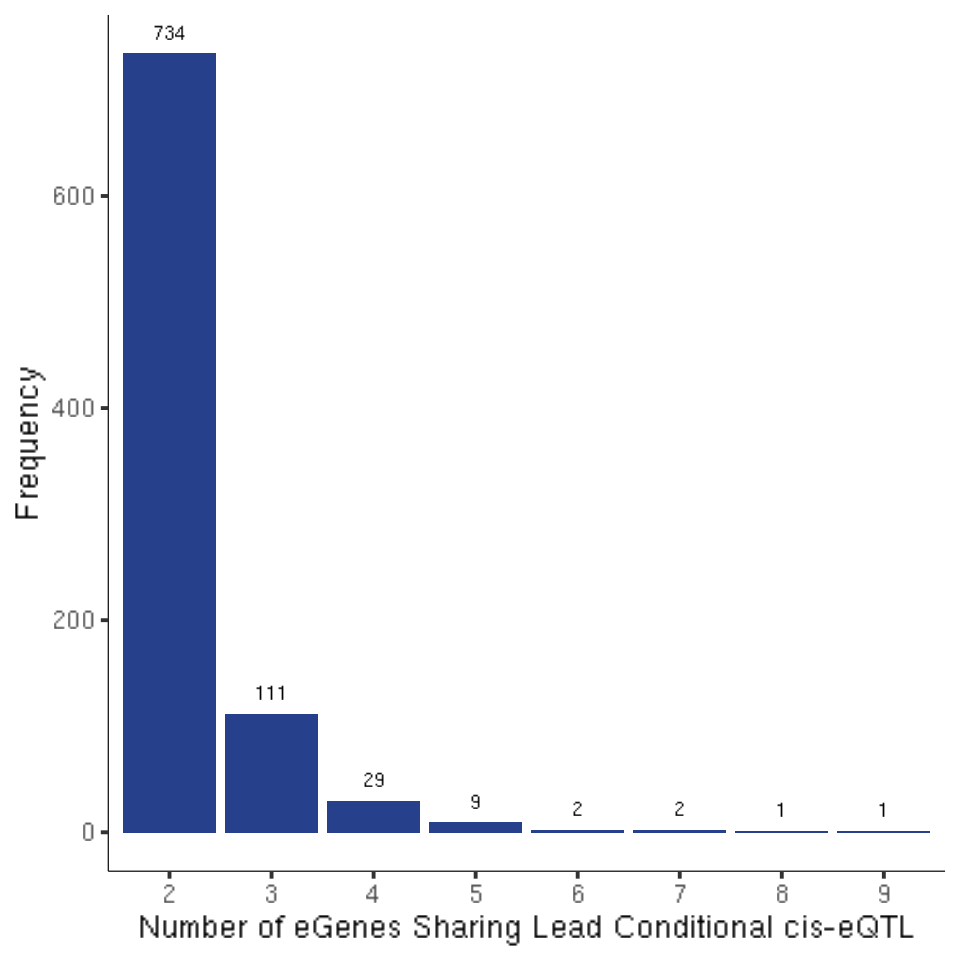

In [7]:
options(repr.plot.width=8, repr.plot.height=8)

as.matrix(table(sapply(cis.eqtl.sets, nrow))) %>%
    as.data.frame() %>%
    dplyr::mutate(N.eGenes=rownames(.)) %>%
    dplyr::select(N.eGenes, cis.eQTL=1) %>%
    ggplot() +
    geom_bar(aes(x=N.eGenes, y=cis.eQTL), stat="identity", fill="royalblue4") +
    geom_text(aes(x=N.eGenes, y=cis.eQTL, label=cis.eQTL), vjust=-1) +
    xlab("Number of eGenes Sharing Lead Conditional cis-eQTL") + ylab("Frequency") +
    ggplot_theme

ggsave("01_Colocalization/results/cis_eqtl_shared_egenes.pdf", width=8, height=8)

Number of pairs that will be tested.

In [8]:
sum(sapply(cis.eqtl.sets, function(x) (nrow(x) * (nrow(x) - 1)) / 2))

[1] 1467

In [9]:
ids <- unlist(lapply(cis.eqtl.sets, function(x) { paste0(x$Gene, "-", x$Number) }))

In [10]:
cis.eqtl.summary <- do.call(rbind, lapply(1:22, function(chr) {
    fread(paste0("/nfs/users/nfs_n/nm18/gains_team282/nikhil/colocalization/cis_eqtl/conditional_effects/LMM/chr", chr, "_conditional_cis_eQTL_summary_statistics.tsv")) %>%
        as.data.frame() %>%
        dplyr::mutate(ID=paste0(Gene, "-", Signal)) %>%
        dplyr::filter(ID %in% ids)
}))

In [11]:
head(cis.eqtl.summary)

,Gene,Signal,Chr,SNP,Position,Beta,SE,P_Value,ID
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSG00000008130,1,1,rs1039063,2350539,0.006760311,0.008101087,0.404103310,ENSG00000008130-1
2,ENSG00000008130,1,1,rs1039064,2350540,-0.009732757,0.011291941,0.388893634,ENSG00000008130-1
3,ENSG00000008130,1,1,rs10399762,1874867,0.048780079,0.016281285,0.002933786,ENSG00000008130-1
4,ENSG00000008130,1,1,rs1040231,2107797,0.030146085,0.012552940,0.016699456,ENSG00000008130-1
5,ENSG00000008130,1,1,rs10449892,1319907,-0.027878728,0.027960376,0.318897193,ENSG00000008130-1
6,ENSG00000008130,1,1,rs10465242,951408,-0.008343425,0.013934597,0.549380611,ENSG00000008130-1


Split summary statistics by locus.

In [12]:
cis.eqtl.loci <- split(cis.eqtl.summary, cis.eqtl.summary$ID)

## Load Gene and Protein Expression

In [13]:
gene.exp <- read.table("/lustre/scratch119/humgen/projects/gains_team282/eqtl/data/logcpm_864_20412_hla.txt")
gene.exp <- t(gene.exp)
rownames(gene.exp) <- gsub("^GA", "", rownames(gene.exp))

In [14]:
head(gene.exp)

,ENSG00000230521,ENSG00000225864,ENSG00000227766,ENSG00000237669,ENSG00000271581,ENSG00000285647,ENSG00000204435,ENSG00000231074,ENSG00000227262,ENSG00000206337,⋯,ENSG00000288253,ENSG00000288302,ENSG00000288349,ENSG00000288393,ENSG00000288398,ENSG00000288538,ENSG00000288559,ENSG00000288562,ENSG00000288573,ENSG00000288582
UK02270173_3,0.6644339,0.9817872,1.2117156,0.6420763,2.474490,0.00000000,3.704888,4.027339,0.06866465,7.318038,⋯,0.5247755,1.3000450,0.5247755,0.92735960,1.133738,1.1337380,0.9457312,0.87079780,0.31467050,2.811486
UK15130120_3,0.5827160,0.4387994,0.3068267,0.6925683,1.331531,0.03379072,4.261280,3.634898,0.25046090,6.369198,⋯,0.5125515,1.7424980,0.4883840,0.06680807,1.860177,0.6496258,0.9264084,0.06680807,0.22143010,3.343063
UK58000006_3,0.4046756,0.6022344,0.6625010,0.9792012,1.831046,0.00000000,3.719682,3.597655,0.00000000,6.837021,⋯,0.2947282,1.5250610,0.6326824,0.66250100,1.315821,1.4755270,1.0258310,0.29472820,0.13374420,4.010874
UK47010004_3,0.2090516,0.9234049,0.7996329,0.6992958,2.475317,0.05517067,4.169617,3.016982,0.30321616,7.723203,⋯,0.3032162,0.9527571,1.0911770,0.30321620,1.143029,1.8370600,0.7669565,0.25690200,0.10830900,2.610379
UK42020088_5,0.2211571,0.2211571,0.6445686,0.3765156,1.881204,0.67482702,4.527758,3.624300,0.04702687,6.350747,⋯,0.0925691,1.2174450,0.6748270,0.13671760,1.088510,2.0637890,0.8172741,0.04702687,0.22115710,2.434768
UK47490007_3,0.4288519,1.1450686,0.3130290,1.0756817,2.053137,0.00000000,4.581986,3.101136,0.00000000,6.728267,⋯,0.5012039,1.9916780,1.1895390,0.35267880,1.211271,0.7590055,0.6033524,1.02749800,0.09657541,3.816079


## COLOC

In [15]:
coloc.res <- do.call(rbind, lapply(names(cis.eqtl.sets), function(snp) {
    
    cis.eqtl.set = cis.eqtl.sets[[snp]]
    cis.eqtl.combinations = combn(paste0(cis.eqtl.set$Gene, "-", cis.eqtl.set$Number), 2)

    signal.res = do.call(rbind, lapply(1:ncol(cis.eqtl.combinations), function(i) {

        id.1 = cis.eqtl.combinations[1, i]
        gene.1 = gsub("-.*", "", id.1)
        id.2 = cis.eqtl.combinations[2, i]
        gene.2 = gsub("-.*", "", id.2)
        
        cis.eqtl.loci[[id.1]] <- cis.eqtl.loci[[id.1]] %>%
            dplyr::filter(!is.na(Beta))
        cis.eqtl.loci[[id.2]] <- cis.eqtl.loci[[id.2]] %>%
            dplyr::filter(!is.na(Beta))

        cis.eqtl.1 <- list()
        cis.eqtl.1$beta <- cis.eqtl.loci[[id.1]]$Beta
        cis.eqtl.1$varbeta <- cis.eqtl.loci[[id.1]]$SE^2
        cis.eqtl.1$snp <- cis.eqtl.loci[[id.1]]$SNP
        cis.eqtl.1$position <- cis.eqtl.loci[[id.1]]$Position
        cis.eqtl.1$type <- "quant"
        cis.eqtl.1$sdY <- sd(gene.exp[,gene.1], na.rm=TRUE)
        
        cis.eqtl.2 <- list()
        cis.eqtl.2$beta <- cis.eqtl.loci[[id.2]]$Beta
        cis.eqtl.2$varbeta <- cis.eqtl.loci[[id.2]]$SE^2
        cis.eqtl.2$snp <- cis.eqtl.loci[[id.2]]$SNP
        cis.eqtl.2$position <- cis.eqtl.loci[[id.2]]$Position
        cis.eqtl.2$type <- "quant"
        cis.eqtl.2$sdY <- sd(gene.exp[,gene.2], na.rm=TRUE)
        
        log = capture.output({
            abf.res = suppressWarnings(coloc.abf(cis.eqtl.1, cis.eqtl.2))
        })

        abf.res.df = data.frame(t(abf.res$summary))
        abf.res.df$SNP = snp
        abf.res.df$Gene.1 = gene.1
        abf.res.df$eQTL.Signal.1 = gsub(".*-", "", id.1)
        abf.res.df$Gene.2 = gene.2
        abf.res.df$eQTL.Signal.2 = gsub(".*-", "", id.2)

        return(abf.res.df)
    }))
}))

## Colocalizing Loci

Confirm that the expected number of pairs were tested.

In [16]:
nrow(coloc.res)

[1] 1467

In [17]:
sum(sapply(
    split(coloc.res, coloc.res$SNP),
    function(x) {
        pairs.colocalizing = sum((x$PP.H3.abf + x$PP.H4.abf > 0.25) & (x$PP.H4.abf / (x$PP.H3.abf + x$PP.H4.abf) > 0.7))
        return(pairs.colocalizing == nrow(x))
    }
))

confident.eqtl <- names(which(sapply(
    split(coloc.res, coloc.res$SNP),
    function(x) {
        pairs.colocalizing = sum((x$PP.H3.abf + x$PP.H4.abf > 0.25) & (x$PP.H4.abf / (x$PP.H3.abf + x$PP.H4.abf) > 0.7))
        return(pairs.colocalizing == nrow(x))
    }
)))

[1] 871

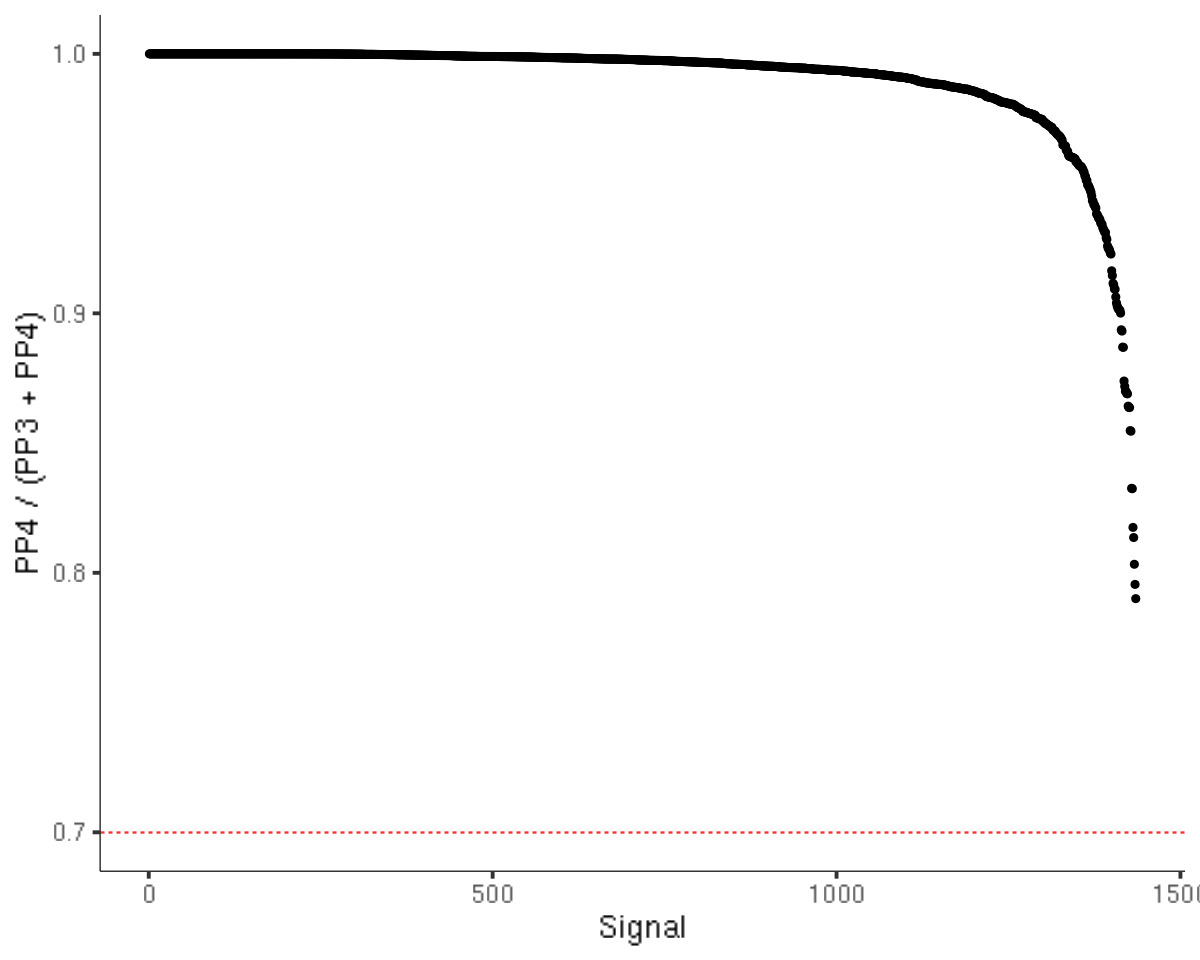

In [18]:
options(repr.plot.width=10, repr.plot.height=8)

coloc.res %>%
    dplyr::filter(SNP %in% confident.eqtl) %>%
    dplyr::mutate(Coloc.Factor=PP.H4.abf / (PP.H3.abf + PP.H4.abf)) %>%
    dplyr::mutate(Rank=rank(-Coloc.Factor, ties.method="first")) %>%
    ggplot() +
    geom_point(aes(x=Rank, y=Coloc.Factor)) +
    geom_hline(aes(yintercept=0.7), lty=2, color="firebrick1") +
    xlab("Signal") + ylab("PP4 / (PP3 + PP4)") +
    ggplot_theme

In [19]:
colocalizing <- coloc.res %>%
    dplyr::filter(SNP %in% confident.eqtl) %>%
    dplyr::mutate(Coloc.Factor=PP.H4.abf / (PP.H3.abf + PP.H4.abf)) %>%
    dplyr::arrange(SNP, desc(Coloc.Factor))

In [20]:
nrow(colocalizing)

[1] 1435

In [21]:
length(unique(colocalizing$SNP))

[1] 871

In [22]:
head(colocalizing)

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,SNP,Gene.1,eQTL.Signal.1,Gene.2,eQTL.Signal.2,Coloc.Factor
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,3022,1.400934e-163,8.233386e-107,6.167736e-59,3.528351e-02,0.9647165,rs10028155,ENSG00000163293,1,ENSG00000259959,1,0.9647165
2,2456,4.373048e-66,1.600806e-53,2.731778e-16,4.547474e-16,1.0000000,rs10076182,ENSG00000113240,2,ENSG00000169131,1,1.0000000
3,2561,3.349046e-63,1.006833e-27,2.339569e-38,6.039551e-03,0.9939604,rs10083027,ENSG00000251301,1,ENSG00000273824,1,0.9939604
4,3208,3.636658e-293,3.856670e-86,1.158459e-210,2.287724e-04,0.9997712,rs10090551,ENSG00000147408,1,ENSG00000279858,1,0.9997712
5,2528,4.373465e-33,6.359011e-07,7.780857e-30,1.314676e-04,0.9998679,rs10099003,ENSG00000104518,2,ENSG00000204839,2,0.9998685
6,3559,9.023103e-23,4.185341e-13,2.156059e-13,8.214083e-08,0.9999999,rs10128882,ENSG00000111052,1,ENSG00000111058,1,0.9999999


In [23]:
colocalizing %>%
    dplyr::group_by(SNP) %>%
    dplyr::summarize(Genes=length(union(Gene.1, Gene.2))) %>%
    dplyr::arrange(desc(Genes)) %>%
    tail()

SNP,Genes
<chr>,<int>
rs999185,2
rs13145977,1
rs16928163,1
rs2461838,1
rs3176820,1
rs62234781,1


In [24]:
write.csv(colocalizing, "/nfs/users/nfs_n/nm18/gains_team282/nikhil/colocalization/cis_eqtl/cis_eqtl_colocalization.csv", row.names=F, quote=F)

## Examples of Clusters of Colocalizing cis-eQTL

In [25]:
gene.info <- read.table("/nfs/team282/data/gains_team282/gene_info_864_20412_hla.txt")

### Most Shared eGenes

In [26]:
snp = "rs3176820"

snp.coloc <- colocalizing %>%
    dplyr::filter(SNP == snp)

genes <- union(
    paste0(snp.coloc$Gene.1, "-", snp.coloc$eQTL.Signal.1),
    paste0(snp.coloc$Gene.2, "-", snp.coloc$eQTL.Signal.2)
)

gene.info[union(snp.coloc$Gene.1, snp.coloc$Gene.2),1:14]

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,gene_version,gene_name,gene_source,gene_biotype
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<int>,<chr>,<chr>,<chr>
ENSG00000230074,9,34665607,34681981,16375,+,havana,gene,NA,NA,ENSG00000230074,3,AL162231.2,havana,lncRNA


In [27]:
geno <- fread("~/gains_team282/nikhil/data/genotypes/eqtl_genotypes_9.raw", drop=2:6, sep=" ") %>%
    as.data.frame()

rownames(geno) <- geno$FID
geno$FID <- NULL
colnames(geno) <- gsub("_.*", "", colnames(geno))
geno <- as.matrix(geno)

In [28]:
ld.snps <- unique(cis.eqtl.summary$SNP[cis.eqtl.summary$ID %in% genes])
locus.ld <- cor(geno[, intersect(ld.snps, colnames(geno))], use="pairwise.complete.obs")

In [29]:
ld.info <- as.data.frame(locus.ld[, snp]) %>%
    dplyr::select(LD=1) %>%
    dplyr::mutate(SNP=rownames(.), LD=LD^2)

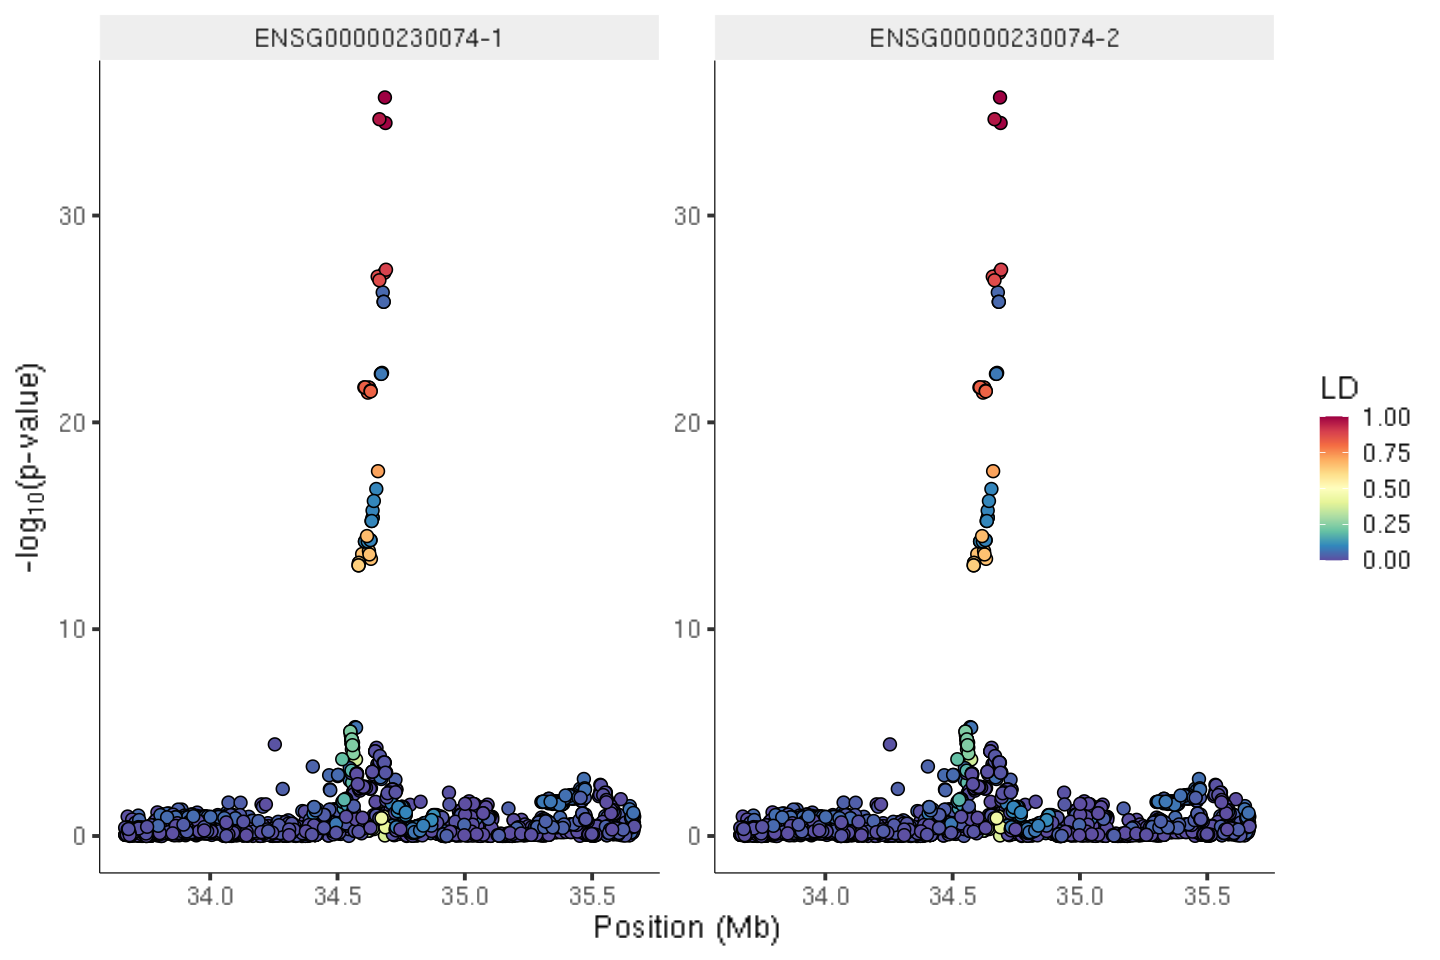

In [30]:
options(repr.plot.width=12, repr.plot.height=8)

palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(11, "Spectral")))

cis.eqtl.summary %>%
    dplyr::filter(ID %in% genes) %>%
    merge(., ld.info, by="SNP") %>%
    ggplot() +
    geom_point(aes(x=Position / 10^6, y=-log10(P_Value), fill=LD), pch=21, size=I(3)) +
    scale_fill_gradientn(colors=palette(100), limits=c(0, 1)) +
    facet_wrap(ID ~ ., scales="free_y") +
    xlab("Position (Mb)") + ylab(bquote("-log"[10]*"(p-value)")) +
    ggplot_theme +
    theme(legend.position="right")

### TCR Region

In [31]:
snp = "rs3114489"

snp.coloc <- colocalizing %>%
    dplyr::filter(SNP == snp)

genes <- union(
    paste0(snp.coloc$Gene.1, "-", snp.coloc$eQTL.Signal.1),
    paste0(snp.coloc$Gene.2, "-", snp.coloc$eQTL.Signal.2)
)

gene.info[union(snp.coloc$Gene.1, snp.coloc$Gene.2),1:14]

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,gene_version,gene_name,gene_source,gene_biotype
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<int>,<chr>,<chr>,<chr>
ENSG00000211751,7,142791694,142793368,1675,+,havana,gene,NA,NA,ENSG00000211751,9,TRBC1,havana,TR_C_gene
ENSG00000211767,7,142796847,142796895,49,+,havana,gene,NA,NA,ENSG00000211767,1,TRBJ2-3,havana,TR_J_gene
ENSG00000281958,7,142788225,142788275,51,+,havana,gene,NA,NA,ENSG00000281958,1,TRBJ1-4,havana,TR_J_gene
ENSG00000282173,7,142788498,142788547,50,+,havana,gene,NA,NA,ENSG00000282173,1,TRBJ1-5,havana,TR_J_gene
ENSG00000282420,7,142787017,142787064,48,+,havana,gene,NA,NA,ENSG00000282420,1,TRBJ1-2,havana,TR_J_gene
ENSG00000282780,7,142788988,142789040,53,+,havana,gene,NA,NA,ENSG00000282780,1,TRBJ1-6,havana,TR_J_gene


In [32]:
geno <- fread("~/gains_team282/nikhil/data/genotypes/eqtl_genotypes_7.raw", drop=2:6, sep=" ") %>%
    as.data.frame()

rownames(geno) <- geno$FID
geno$FID <- NULL
colnames(geno) <- gsub("_.*", "", colnames(geno))
geno <- as.matrix(geno)

In [33]:
ld.snps <- unique(cis.eqtl.summary$SNP[cis.eqtl.summary$ID %in% genes])
locus.ld <- cor(geno[, intersect(ld.snps, colnames(geno))], use="pairwise.complete.obs")

In [34]:
ld.info <- as.data.frame(locus.ld[, snp]) %>%
    dplyr::select(LD=1) %>%
    dplyr::mutate(SNP=rownames(.), LD=LD^2)

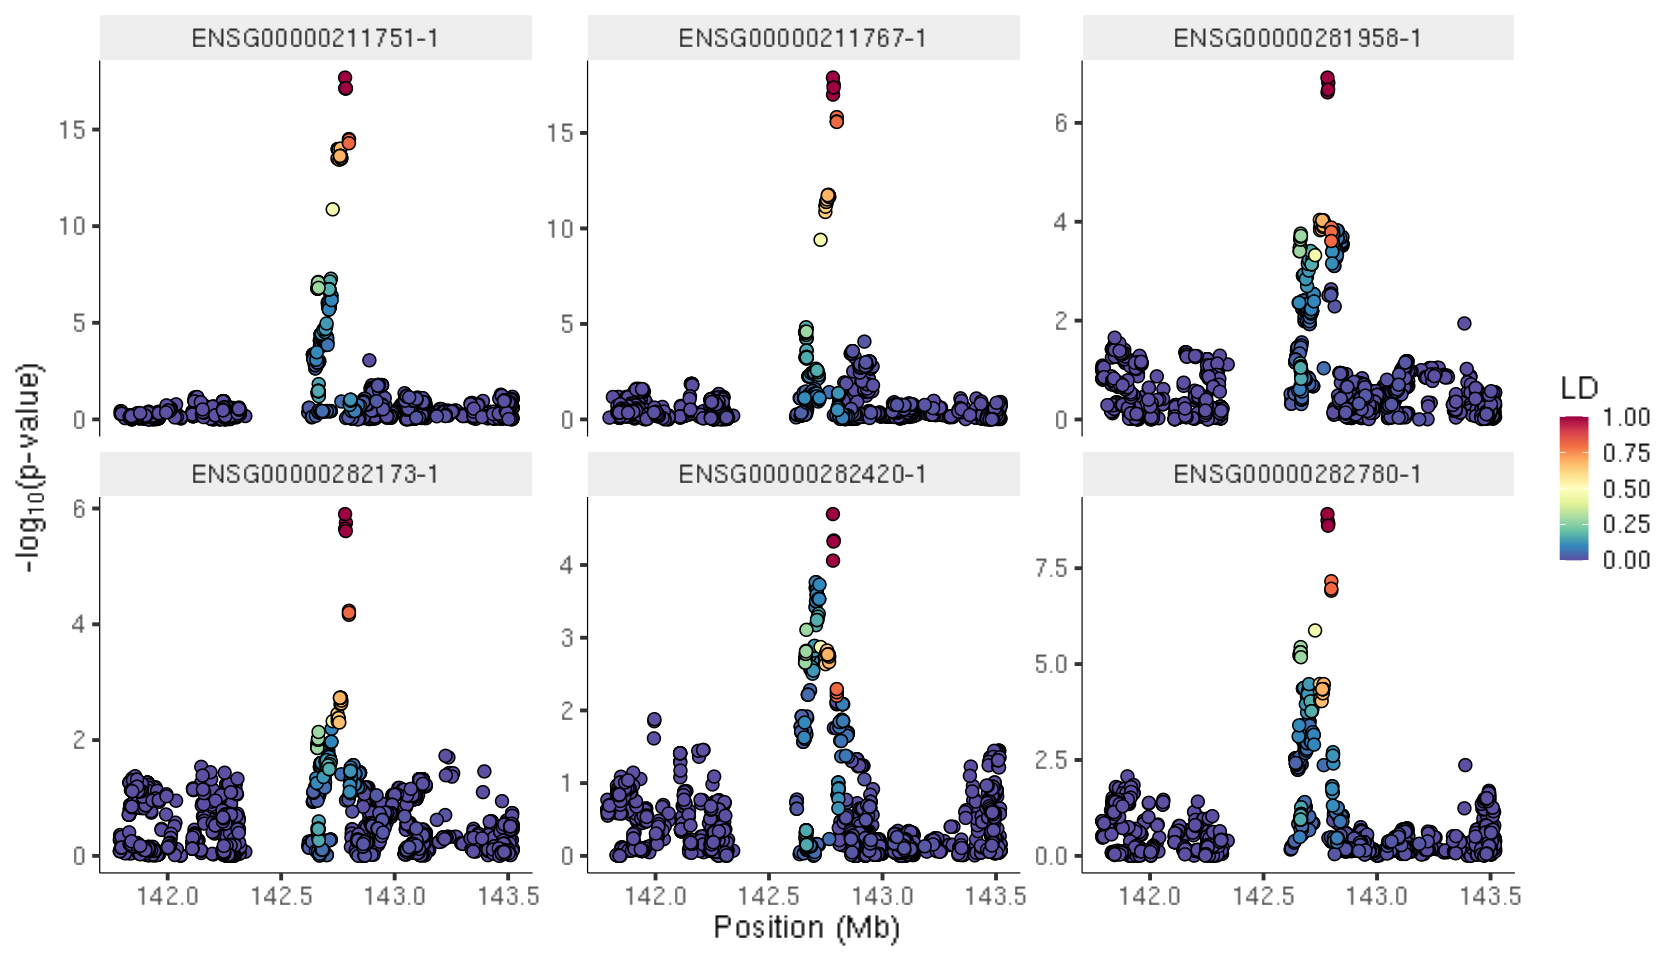

In [42]:
options(repr.plot.width=14, repr.plot.height=8)

palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(11, "Spectral")))

cis.eqtl.summary %>%
    dplyr::filter(ID %in% genes) %>%
    merge(., ld.info, by="SNP") %>%
    dplyr::arrange(LD, desc(P_Value)) %>%
    ggplot() +
    geom_point(aes(x=Position / 10^6, y=-log10(P_Value), fill=LD), pch=21, size=I(3)) +
    scale_fill_gradientn(colors=palette(100), limits=c(0, 1)) +
    facet_wrap(ID ~ ., scales="free_y") +
    xlab("Position (Mb)") + ylab(bquote("-log"[10]*"(p-value)")) +
    ggplot_theme +
    theme(legend.position="right")

ggsave("01_Colocalization/results/cis_eqtl_tcr.pdf", width=14, height=8)

## Potential Modules of Interest

In [96]:
mqtl.snps <- read.csv("~/gains_team282/nikhil/expression/eigengene_sva/all_mqtl_all_pcs.csv")

How many of the 871 lead conditional cis-eQTL are also module QTL?

In [100]:
sum(unique(colocalizing$SNP) %in% mqtl.snps$snp)

[1] 77

How many modules might be associated with these cis-eQTL?

In [103]:
mqtl.snps %>%
    dplyr::filter(snp %in% colocalizing$SNP) %>%
    dplyr::group_by(me) %>%
    dplyr::summarize(N=n()) %>%
    nrow()

[1] 37

In [157]:
mqtl.snps %>%
    dplyr::filter(snp %in% colocalizing$SNP) %>%
    dplyr::group_by(me) %>%
    dplyr::summarize(N=n(), SNPs=paste0(snp, collapse="|"))

me,N,SNPs
<chr>,<int>,<chr>
ME_101,3,rs1293259|rs614997|rs117089113
ME_102,2,rs2461838|rs629329
ME_103,1,rs4761234
ME_104,5,rs12438138|rs8024288|rs8023725|rs36053285|rs7180844
ME_106,4,rs7947900|rs7944394|rs11246068|rs7395319
ME_42,1,rs2294758
ME_46,1,rs4782425
ME_47,1,rs16843927
ME_51,2,rs10938506|rs10028155
